In [ ]:
import zipfile
with zipfile.ZipFile("RGB.zip",'r') as zip_ref:
  zip_ref.extractall("RGB")

with zipfile.ZipFile("annotations.zip",'r') as zip_ref:
  zip_ref.extractall('annotations')


File unzipped!


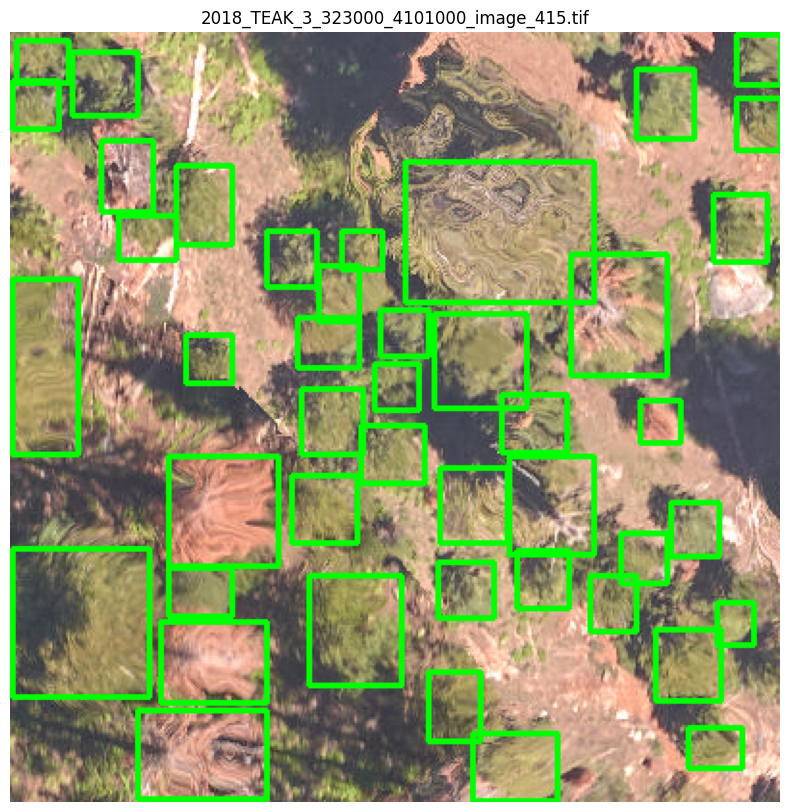

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


annotations_dir = "annotations/annotations"
rgb_dir = "RGB/RGB"


sample_xml = os.listdir(annotations_dir)[0]
xml_path = os.path.join(annotations_dir, sample_xml)


tree = ET.parse(xml_path)
root = tree.getroot()


image_filename = root.find("filename").text
image_path = os.path.join(rgb_dir, image_filename)


image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")


for obj in root.findall("object"):
    bbox = obj.find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title(image_filename)
plt.axis('off')
plt.show()


In [16]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
def parse_annotation(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bboxes = []

  for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    bboxes.append((xmin, ymin, xmax, ymax))

  return bboxes

In [ ]:
def draw_bounding_boxes(image_path, bboxes):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  for (xmin, ymin, xmax, ymax) in bboxes:
    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0, 255, 0), 2)

  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.axis("off")
  plt.show()

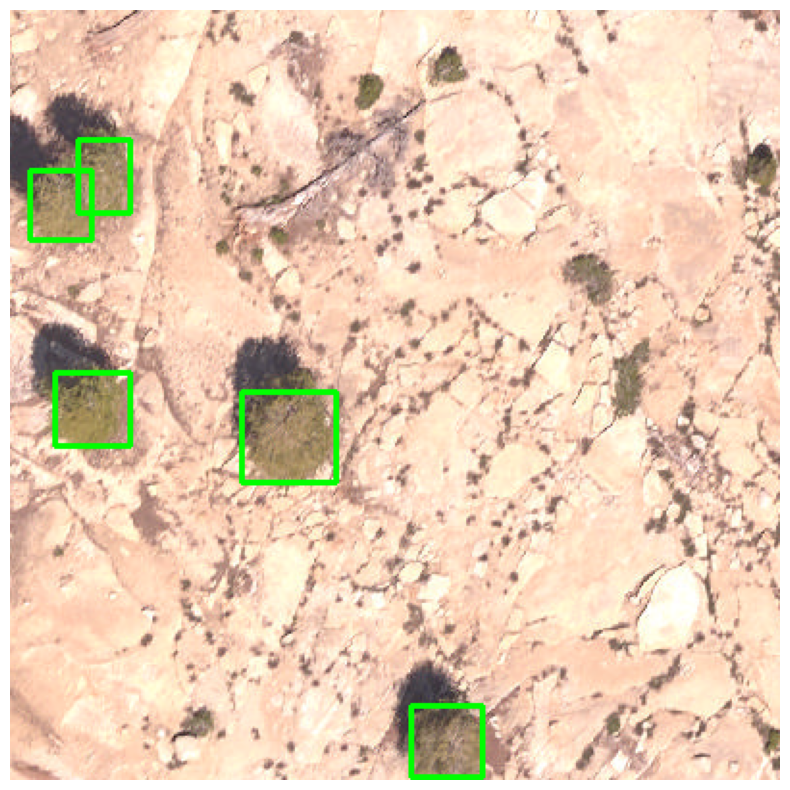

In [ ]:
# Example file (replace with actual file names in your data)
example_image = '/content/RGB/RGB/2018_TEAK_3_322000_4107000_image_518.tif'
example_xml = '/content/annotations/annotations/2018_TEAK_3_322000_4107000_image_518.xml'

bboxes = parse_annotation(example_xml)
draw_bounding_boxes(example_image, bboxes)


In [14]:
import os

# Define the path where you want to save the cropped crowns
output_dir = "/content/cropped_crowns"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")


Created directory: /content/cropped_crowns


In [18]:
def crop_and_save_crowns(annotation_dir, rgb_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory at {output_dir}")
    else:
        print(f"Output directory exists: {output_dir}")

    xml_files = [f for f in os.listdir(annotation_dir) if f.endswith('.xml')]

    for xml_file in xml_files:
        xml_path = os.path.join(annotation_dir, xml_file)
        image_name = xml_file.replace('.xml', '.tif')  # or .jpg if that's what you uploaded
        image_path = os.path.join(rgb_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found for {image_name}, skipping.")
            continue

        bboxes = parse_annotation(xml_path)
        image = cv2.imread(image_path)

        for idx, (xmin, ymin, xmax, ymax) in enumerate(bboxes):
            crown = image[ymin:ymax, xmin:xmax]
            crop_name = f"{os.path.splitext(image_name)[0]}_crown_{idx}.jpg"
            crop_path = os.path.join(output_dir, crop_name)
            cv2.imwrite(crop_path, crown)

    print("✅ All crowns cropped and saved.")


In [20]:
crop_and_save_crowns("/content/annotations/annotations", "/content/RGB/RGB", "/content/cropped_crowns")


Output directory exists: /content/cropped_crowns
Image not found for 4.tif, skipping.
Image not found for 2018_MLBS_3_541000_4140000_image_crop.tif, skipping.
Image not found for 2018_MLBS_3_541000_4140000_image_crop2.tif, skipping.
Image not found for 6.tif, skipping.
Image not found for 9.tif, skipping.
Image not found for 2019_LENO_5_383000_3523000_image_crop.tif, skipping.
Image not found for 2018_OSBS_4_405000_3286000_image.tif, skipping.
Image not found for 2019_SJER_4_251000_4103000_image.tif, skipping.
Image not found for 2019_ONAQ_2_367000_4449000_image_crop.tif, skipping.
Image not found for 2019_OSBS_5_405000_3287000_image_crop2.tif, skipping.
Image not found for 15.tif, skipping.
Image not found for 8.tif, skipping.
Image not found for 2018_SJER_3_252000_4113000_image_310.tif, skipping.
Image not found for 2018_SJER_3_253000_4108000_image_721.tif, skipping.
Image not found for 2019_OSBS_5_405000_3287000_image_crop.tif, skipping.
Image not found for 10.tif, skipping.
Image n

In [21]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Input and output
cropped_dir = "/content/cropped_crowns"
preprocessed_dir = "/content/preprocessed_crowns"
target_size = (128, 128)

# Create output folder
os.makedirs(preprocessed_dir, exist_ok=True)

# Preprocess images
for img_name in tqdm(os.listdir(cropped_dir)):
    img_path = os.path.join(cropped_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    # Resize and normalize
    resized = cv2.resize(img, target_size)
    normalized = resized / 255.0  # optional normalization

    # Save as .npy (numpy array)
    np.save(os.path.join(preprocessed_dir, img_name.replace('.jpg', '.npy')), normalized)

print("✅ All images preprocessed and saved as .npy")


100%|██████████| 6633/6633 [00:31<00:00, 213.28it/s]

✅ All images preprocessed and saved as .npy


In [22]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.imread(image_path)
    if image is None:
        return None

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()


cropped_dir = "/content/cropped_crowns"
features = []
image_paths = []

for file in tqdm(os.listdir(cropped_dir)):
    path = os.path.join(cropped_dir, file)
    hist = extract_color_histogram(path)
    if hist is not None:
        features.append(hist)
        image_paths.append(path)

features = np.array(features)

100%|██████████| 6633/6633 [00:00<00:00, 8245.93it/s]


In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

from collections import Counter
print("Cluster distribution:", Counter(labels))


Cluster distribution: Counter({np.int32(1): 3450, np.int32(0): 3183})



Showing 5 samples from cluster 0


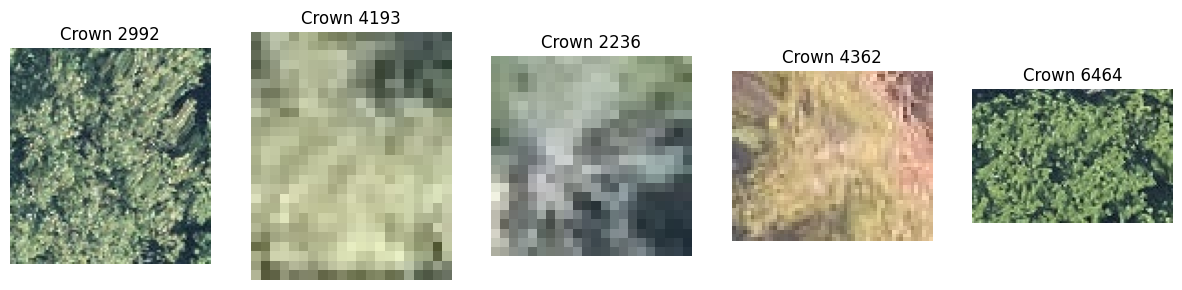


Showing 5 samples from cluster 1


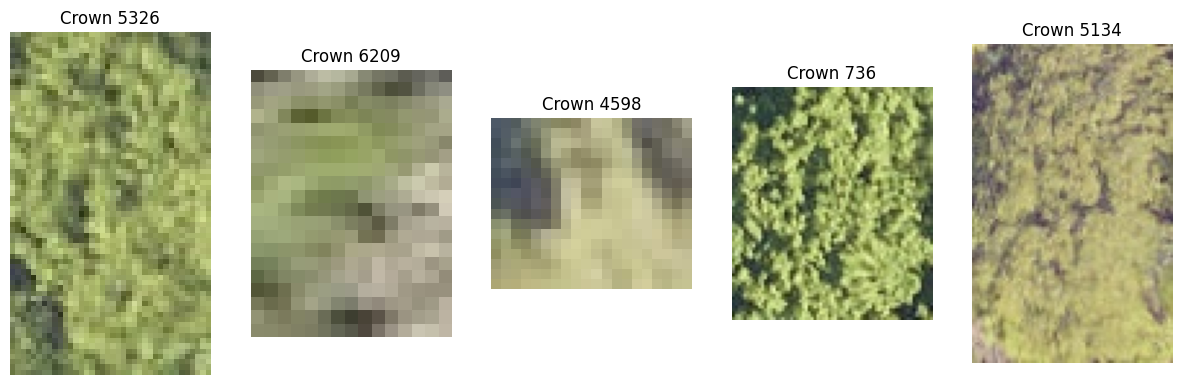

In [24]:
import random

def show_cluster_samples(cluster_id, n=5):
    print(f"\nShowing {n} samples from cluster {cluster_id}")
    indices = [i for i, label in enumerate(labels) if label == cluster_id]
    chosen = random.sample(indices, min(n, len(indices)))

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(chosen):
        img = cv2.imread(image_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img_rgb)
        plt.title(f"Crown {idx}")
        plt.axis("off")
    plt.show()

show_cluster_samples(0)
show_cluster_samples(1)
